## Introduction
The purpose of this notebook is to show how to perform inference on quadrat test images with a tiling-based approach. As you may have have already noticed, predicting the species directly on the entire high-resolution image is a challenging task that often yields suboptimal results. The more intuitive strategy is then split the image into smaller patches, predict the species on each patch and finally aggregate the results.

Here we use a simple method where predictions are thresholded based on species scores and their relative positions among the softmax output. The predictions for each tile are generated using the DINOv2-based model provided in the competition.
This notebook can be used as a starting point for further development. Feel free to leave comments on errors or for any improvement.

### Import libraries

In [20]:
import numpy as np
import pandas as pd
import timm
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import time
import os
import torchvision.transforms as T
from torch.amp import autocast
from matplotlib import pyplot as plt
from kornia import tensor_to_image
from kornia.contrib import extract_tensor_patches, compute_padding
import csv

In [3]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class PatchDataset(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches.squeeze(0)
        self.transform = transform

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]

        if self.transform:
            patch = self.transform(patch)
        return patch


class TestDataset(Dataset):
    def __init__(
        self, image_folder, patch_size=518, stride=259, transform=None, use_pad=False
    ):
        self.image_folder = image_folder
        self.image_paths = [
            os.path.join(image_folder, f) for f in os.listdir(image_folder)
        ]
        self.transform = transform
        self.use_pad = use_pad
        self.patch_size = patch_size
        self.stride = stride

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image).unsqueeze(0)

        h, w = image.shape[-2:]

        if self.use_pad:
            pad = compute_padding(
                original_size=(h, w), window_size=self.patch_size, stride=self.stride
            )
            patches = extract_tensor_patches(
                image, self.patch_size, self.stride, padding=pad
            )
        else:
            patches = extract_tensor_patches(image, self.patch_size, self.stride)

        return patches, image_path

In [14]:
df_species_ids = pd.read_csv("/kaggle/input/plantclef-2025/species_ids.csv")

df_metadata = pd.read_csv(
    "/kaggle/input/plantclef-2025/PlantCLEF2024_single_plant_training_metadata.csv",
    sep=";",
    dtype={"partner": str},
)
class_map = df_species_ids[
    "species_id"
].to_dict()  # dictionary to map the species model Id with the species Id

df_metadata.head()

,image_name,organ,species_id,obs_id,license,partner,author,altitude,latitude,longitude,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg,leaf,1396710,1008726402,cc-by-sa,NaN,Gulyás Bálint,205.9261,47.592160,19.362895,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/59feabe1c98f06...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,dc273995a89827437d447f29a52ccac86f65476e.jpg,leaf,1396710,1008724195,cc-by-sa,NaN,vadim sigaud,323.7520,47.906703,7.201746,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/dc273995a89827...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,416235e7023a4bd1513edf036b6097efc693a304.jpg,leaf,1396710,1008721908,cc-by-sa,NaN,fil escande,101.3160,48.826774,2.352774,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/416235e7023a4b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
3,cbd18fade82c46a5c725f1f3d982174895158afc.jpg,leaf,1396710,1008699177,cc-by-sa,NaN,Desiree Verver,5.1070,52.190427,6.009677,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/cbd18fade82c46...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
4,f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg,leaf,1396710,1008683100,cc-by-sa,NaN,branebrane,165.3390,45.794739,15.965862,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/f82c8c6d570287...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


In [5]:
device = torch.device("cuda")
model = timm.create_model(
    "vit_base_patch14_reg4_dinov2.lvd142m",
    pretrained=False,
    num_classes=len(df_species_ids),
    checkpoint_path="/kaggle/input/dinov2_patch14_reg4_onlyclassifier_then_all/pytorch/default/3/model_best.pth.tar",
)
model = model.to(device)
model = model.eval()

In [6]:
data_config = timm.data.resolve_model_data_config(model)
model_input_size, model_mean, model_std = (
    data_config["input_size"][1],
    data_config["mean"],
    data_config["std"],
)

Set hyperparameters:
* batch_size: size of batch of testing images
* top_k: keep best top_k results for each patch
* min_score: keep only classes with a score higher than min_score
* patch_size: size of patches. We will be using the DinoV2 image input size that is 518.
* stride: overlapping stride. We will be using half of the patch size.

In [7]:
batch_size = 64
min_score = 0.1
top_k_tile = 2
patch_size = model_input_size
stride = int(model_input_size / 2)
use_pad = True

Exemple of tiling on single image. Let's load a random image

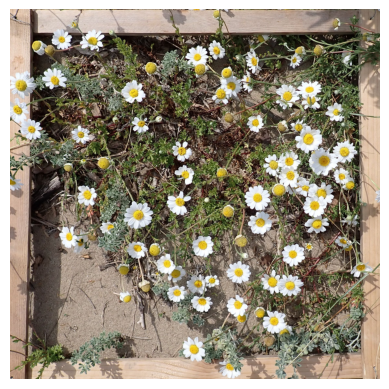

In [8]:
img = Image.open(
    "/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/GUARDEN-CBNMed-30-4-16-3-20240428.jpg"
)
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
image_to_tensor = T.ToTensor()

image_tensor = image_to_tensor(img).unsqueeze(0)
h, w = image_tensor.shape[-2:]

pad = compute_padding(original_size=(h, w), window_size=patch_size, stride=stride)

patches = extract_tensor_patches(image_tensor, patch_size, stride, padding=pad)
print(f"Shape of image tiles = {patches.shape}")

Shape of image tiles = torch.Size([1, 64, 3, 518, 518])


Let's now visualize the 64 patches extracted with a size of 518 (the same of model input)

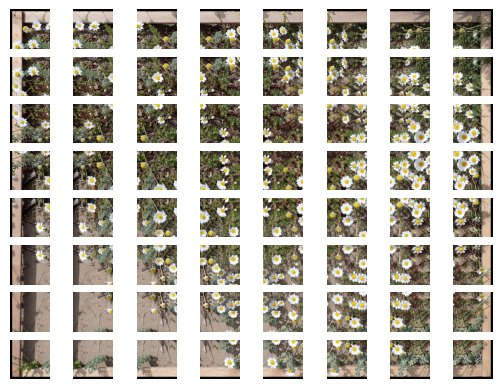

In [10]:
fig, axs = plt.subplots(8, 8)
axs = axs.ravel()

for i in range(len(patches[0])):
    axs[i].axis("off")
    axs[i].imshow(tensor_to_image(patches[0][i]))

plt.show()

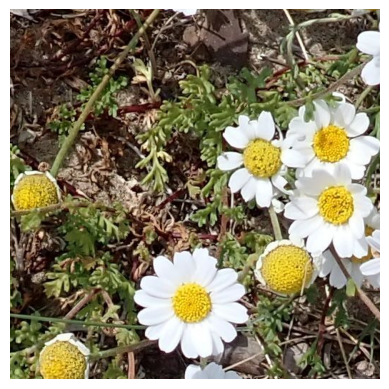

In [11]:
# Example of a single patch
plt.imshow(tensor_to_image(patches[0][29]))
plt.axis("off")
plt.show()

Run over all the test dataset

In [18]:
dataset = TestDataset(
    image_folder="/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/",
    patch_size=patch_size,
    stride=stride,
    use_pad=True,
    transform=image_to_tensor,
)
dataloader = DataLoader(dataset, batch_size=1, num_workers=4, pin_memory=True)

image_predictions = {}

# Initialize batch time tracking
batch_time = AverageMeter()
end = time.time()

with torch.no_grad():
    for batch_idx, (patches, image_path) in enumerate(dataloader):
        image_results = {}
        quadrat_id = os.path.splitext(os.path.basename(image_path[0]))[0]
        transform_patch = T.Normalize(mean=model_mean, std=model_std)
        patch_dataset = PatchDataset(patches[0], transform=transform_patch)
        patch_loader = DataLoader(patch_dataset, batch_size=batch_size, shuffle=False)

        for batch_patches in patch_loader:
            batch_patches = batch_patches.to(device)

            with autocast("cuda"):
                outputs = model(batch_patches)  # Perform inference on the batch
                probabilities = torch.nn.functional.softmax(outputs, dim=1)

                # Get the top-k indices and probabilities
                top_probs, top_indices = torch.topk(probabilities, top_k_tile)
                top_probs = top_probs.cpu().numpy()
                top_indices = top_indices.cpu().numpy()

                for top_tile_indices, top_tile_probs in zip(top_indices, top_probs):
                    for top_idx, top_prob in zip(top_tile_indices, top_tile_probs):
                        species_id = class_map[top_idx]
                        # Update the results dictionary only if the probability is higher
                        if top_prob > min_score:
                            if (
                                top_idx not in image_results
                                or image_results[top_idx] < top_prob
                            ):
                                image_results[species_id] = top_prob
        # store the prediction
        image_predictions[quadrat_id] = list(image_results.keys())

        batch_time.update(time.time() - end)
        end = time.time()

        # Log info at specified frequency
        if batch_idx % 10 == 0:  # You can set your log frequency here
            print(
                f"Predict: [{batch_idx}/{len(dataloader)}] "
                f"Time {batch_time.val:.3f} ({batch_time.avg:.3f})"
            )

Submit prediction

In [27]:
df_run = pd.DataFrame(
    list(image_predictions.items()), columns=["quadrat_id", "species_ids"]
)
df_run["species_ids"] = df_run["species_ids"].apply(str)
df_run.to_csv("submission.csv", sep=",", index=False, quoting=csv.QUOTE_ALL)